In [106]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
#df = pd.read_csv('data/newyork/train.csv')

In [ ]:
#df.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [20]:
# took a long time to load the datasets, so we'll use a sample rather than the full dataset to iterate faster  and reduce the time taken

#We'll ignore the key column for now, and parse the date time columns

sample_fraction = 0.01

selected_cols = 'fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count'.split(',')

dtypes = {
    'fare_amount': 'float32',
    'pickup_longitude': 'float32',
    'pickup_latitude': 'float32',
    'dropoff_longitude': 'float32',
    'passenger_count': 'float32'
}

random.seed(67)

def skip_row(row_index):
  if row_index == 0:
    return False
  return random.random() > sample_fraction


df = pd.read_csv('data/newyork/train.csv', usecols = selected_cols, dtype = dtypes, parse_dates = ['pickup_datetime'] , skiprows = skip_row)

In [23]:
df

,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,7.300000,2011-06-21 16:15:00+00:00,-73.991875,40.754436,-73.977226,40.774323,3.0
1,4.500000,2015-03-12 08:08:38+00:00,-73.990173,40.756447,-73.985619,40.762829,1.0
2,14.900000,2012-08-28 12:29:40+00:00,-73.992210,40.758865,-73.993797,40.722718,1.0
3,3.700000,2010-09-05 17:08:00+00:00,0.000000,0.000000,0.000000,0.000000,5.0
4,6.500000,2011-01-23 11:44:28+00:00,-74.003662,40.736904,-73.997841,40.724187,1.0
...,...,...,...,...,...,...,...
554366,9.500000,2014-10-14 07:38:50+00:00,-73.995270,40.733929,-73.974960,40.747620,1.0
554367,27.469999,2010-02-15 17:15:00+00:00,-73.961151,40.805981,-73.865173,40.770645,5.0
554368,6.000000,2014-08-18 09:02:20+00:00,-73.950432,40.775360,-73.955780,40.764072,2.0
554369,20.500000,2011-10-26 00:08:32+00:00,-73.993172,40.727749,-73.972496,40.797448,3.0


In [63]:
test_df = pd.read_csv('data/newyork/test.csv', dtype = dtypes, parse_dates= ['pickup_datetime'])

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554371 entries, 0 to 554370
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        554371 non-null  float32            
 1   pickup_datetime    554371 non-null  datetime64[ns, UTC]
 2   pickup_longitude   554371 non-null  float32            
 3   pickup_latitude    554371 non-null  float32            
 4   dropoff_longitude  554368 non-null  float32            
 5   dropoff_latitude   554368 non-null  float64            
 6   passenger_count    554371 non-null  float32            
dtypes: datetime64[ns, UTC](1), float32(5), float64(1)
memory usage: 19.0 MB


In [25]:
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,554371.000000,554371.000000,554371.000000,554368.000000,554368.000000,554371.000000
mean,11.339173,-72.487083,39.904369,-72.475983,39.898209,1.686666
std,9.755569,12.141803,11.652518,12.399942,9.195592,1.314980
min,-95.000000,-2940.049072,-3475.475098,-1749.704590,-3475.475068,0.000000
25%,6.000000,-73.991982,40.734962,-73.991356,40.734068,1.000000
50%,8.500000,-73.981750,40.752720,-73.980133,40.753200,1.000000
75%,12.500000,-73.966927,40.767178,-73.963623,40.768092,2.000000
max,450.000000,2431.418945,3319.333740,2889.997314,473.956992,6.000000


In [27]:
df.isna().sum()

fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    3
dropoff_latitude     3
passenger_count      0
dtype: int64

In [30]:
train_df, val_df= train_test_split(df , test_size= 0.2, random_state= 67)

In [31]:
train_df = train_df.dropna()
val_df = val_df.dropna()

In [32]:
train_df.columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count'],
      dtype='object')

In [33]:
input_cols = ['pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'passenger_count']

target_col = 'fare_amount'

In [34]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

In [35]:
val_inputs = val_df[input_cols]
val_targets = val_df[target_col]

In [37]:
test_inputs= test_df[input_cols]

In [40]:
# Our Baseline Dumb Model
class MeanRegressor:
  def fit(self, inputs, targets):
    self.mean = targets.mean()
  def predict(self, inputs):
    return np.full(inputs.shape[0], self.mean)

In [41]:
mean_model = MeanRegressor()

In [42]:
mean_model.fit(train_inputs,train_targets)  

In [44]:
train_preds = mean_model.predict(train_inputs)

In [45]:
val_preds = mean_model.predict(val_inputs)

In [47]:
root_mean_squared_error(train_preds,train_targets)

9.764459609985352

In [48]:
root_mean_squared_error(val_preds,val_targets)

9.725894927978516

In [50]:
model = LinearRegression()

In [51]:
model.fit(train_inputs,train_targets)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [53]:
preds= model.predict(train_inputs)

In [55]:
root_mean_squared_error(preds, train_targets)

9.76287265060222

In [56]:
def predict_and_submit(model,test_inputs,fname):
  test_preds = model.predict(test_inputs)
  sub_df = pd.read_csv('data/newyork/sample_submission.csv')
  sub_df['fare_amount'] = test_preds
  sub_df.to_csv(fname, index = None)
  return sub_df

In [58]:
predict_and_submit(model , test_inputs, 'linearModel.csv')

,key,fare_amount
0,2015-01-27 13:08:24.0000002,11.260149
1,2015-01-27 13:08:24.0000003,11.260061
2,2011-10-08 11:53:44.0000002,11.260155
3,2012-12-01 21:12:12.0000002,11.260055
4,2012-12-01 21:12:12.0000003,11.260096
...,...,...
9909,2015-05-10 12:37:51.0000002,11.781453
9910,2015-01-12 17:05:51.0000001,11.781426
9911,2015-04-19 20:44:15.0000001,11.783279
9912,2015-01-31 01:05:19.0000005,11.781457


In [59]:
def add_dateparts(df, col):
  df[col + '_year'] = df[col].dt.year
  df[col+ '_month'] = df[col].dt.month
  df[col + '_weekday'] = df[col].dt.weekday
  df[col + '_hour'] = df[col].dt.hour

In [60]:
add_dateparts(train_df,'pickup_datetime')

In [61]:
add_dateparts(val_df, 'pickup_datetime')

In [64]:
add_dateparts(test_df, 'pickup_datetime')

In [65]:
import numpy as np

def haversine_np(lon1, lat1, lon2, lat2):
  """
  Calculate the great circle distance between two points
  on the earth (specified in decimal degrees)

  All args must be of equal length.    

  """
  lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

  dlon = lon2 - lon1
  dlat = lat2 - lat1

  a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

  c = 2 * np.arcsin(np.sqrt(a))
  km = 6367 * c
  return km

In [66]:
def add_trip_distance(df):
  df['trip_distance'] = haversine_np(df['pickup_longitude'], 
                                     df['pickup_latitude'], 
                                     df['dropoff_longitude'], 
                                     df['dropoff_latitude'])

In [67]:
add_trip_distance(train_df)
add_trip_distance(val_df)
add_trip_distance(test_df)

In [68]:
#Adding some landmark locations of newyork city

jfk_lonlat = -73.7781, 40.6413
lga_lonlat = -73.8740, 40.7769
ewr_lonlat = -74.1745, 40.6895
met_lonlat = -73.9632, 40.7794
wtc_lonlat = -74.0099, 40.7126

In [69]:
def add_landmark_dropoff_distance(df, landmark_name, landmark_lonlat):
  lon, lat = landmark_lonlat
  df[landmark_name + '_drop_distance'] = haversine_np(lon, lat, df['dropoff_longitude'], df['dropoff_latitude'])

In [74]:
def add_landmarks(df):
  landmarks = [('jfk', jfk_lonlat), ('lga', lga_lonlat), ('ewr', ewr_lonlat), ('met', met_lonlat), ('wtc', wtc_lonlat)]
  for name, lonlat in landmarks:
    add_landmark_dropoff_distance(df, name, lonlat)

In [75]:
add_landmarks(train_df)
add_landmarks(val_df)
add_landmarks(test_df)

In [77]:
#data cleaning is required
df.describe()

,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
count,554371.000000,554371.000000,554371.000000,554368.000000,554368.000000,554371.000000
mean,11.339173,-72.487083,39.904369,-72.475983,39.898209,1.686666
std,9.755569,12.141803,11.652518,12.399942,9.195592,1.314980
min,-95.000000,-2940.049072,-3475.475098,-1749.704590,-3475.475068,0.000000
25%,6.000000,-73.991982,40.734962,-73.991356,40.734068,1.000000
50%,8.500000,-73.981750,40.752720,-73.980133,40.753200,1.000000
75%,12.500000,-73.966927,40.767178,-73.963623,40.768092,2.000000
max,450.000000,2431.418945,3319.333740,2889.997314,473.956992,6.000000


In [78]:
test_df.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_datetime_year,pickup_datetime_month,pickup_datetime_weekday,pickup_datetime_hour,trip_distance,jfk_drop_distance,lga_drop_distance,ewr_drop_distance,met_drop_distance,wtc_drop_distance
count,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000,9914.000000
mean,-73.974724,40.751041,-73.973663,40.751743,1.671273,2011.815816,6.857979,2.852834,13.467420,3.433217,20.916707,9.675209,18.546655,4.512975,6.037621
std,0.042799,0.033542,0.039093,0.035435,1.278756,1.803347,3.353272,1.994451,6.868584,3.969883,3.303942,3.295656,4.035818,4.018438,4.252537
min,-74.252190,40.573143,-74.263245,40.568973,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000009,0.402057,0.285510,0.284706,0.085728,0.040386
25%,-73.992500,40.736125,-73.991249,40.735254,1.000000,2010.000000,4.000000,1.000000,8.000000,1.297281,20.513366,8.311562,16.520468,2.126326,3.669914
50%,-73.982327,40.753052,-73.980015,40.754065,1.000000,2012.000000,7.000000,3.000000,15.000000,2.215669,21.181394,9.477792,18.024364,3.698360,5.541418
75%,-73.968012,40.767113,-73.964062,40.768757,2.000000,2014.000000,10.000000,5.000000,19.000000,4.042928,21.909781,10.965471,19.880521,5.922760,7.757408
max,-72.986534,41.709557,-72.990967,41.696683,6.000000,2015.000000,12.000000,6.000000,23.000000,99.933359,134.497657,126.062486,149.400789,130.347048,138.619454


In [93]:
#We'll use these conditions for data cleaning

# fare - 1-500
# longitude = = 75 - 72
# latitude = 40 - 42
# passenger = 1 to 6

def remove_outliers(df):
  return df[(df['fare_amount'] >= 1.) & 
            (df['fare_amount'] <= 500.) &
            (df['pickup_longitude'] >= -75) & 
            (df['pickup_longitude'] <= -72) & 
            (df['dropoff_longitude'] >= -75) & 
            (df['dropoff_longitude'] <= -72) & 
            (df['pickup_latitude'] >= 40) & 
            (df['pickup_latitude'] <= 42) & 
            (df['dropoff_latitude'] >=40) & 
            (df['dropoff_latitude'] <= 42) & 
            (df['passenger_count'] >= 1) & 
            (df['passenger_count'] <= 6)]

In [94]:
train_df = remove_outliers(train_df)
val_df = remove_outliers(val_df)

In [95]:
train_df .columns

Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance'],
      dtype='object')

In [96]:
input_cols = [ 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'passenger_count',
       'pickup_datetime_year', 'pickup_datetime_month',
       'pickup_datetime_weekday', 'pickup_datetime_hour', 'trip_distance',
       'jfk_drop_distance', 'lga_drop_distance', 'ewr_drop_distance',
       'met_drop_distance', 'wtc_drop_distance']

target_col = 'fare_amount'

In [97]:
train_inputs = train_df[input_cols]
train_targets = train_df[target_col]

val_inputs = val_df [input_cols]
val_targets = val_df[target_col]

test_inputs = test_df [input_cols]

In [98]:
def evaluate(model):
  train_preds = model.predict(train_inputs)
  train_rmse = root_mean_squared_error(train_preds, train_targets)
  val_preds = model.predict(val_inputs)
  val_rmse = root_mean_squared_error(val_preds, val_targets)
  return train_rmse, val_rmse, train_preds, val_preds

In [99]:
model = Ridge(random_state= 67, alpha= 0.9)

In [100]:
model.fit(train_inputs, train_targets)

,alpha,0.9
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,67


In [101]:
evaluate(model)

(5.029554081733571,
 5.22119669070449,
 array([ 9.74551214, 13.04648252, 10.83985047, ...,  4.35097577,
        28.3849989 ,  6.44481089], shape=(432594,)),
 array([22.67804143,  4.73837617, 16.42246535, ..., 13.68148595,
        12.43899274, 10.23260299], shape=(107990,)))

In [103]:
model = RandomForestRegressor(random_state= 67, n_jobs= -1, max_depth= 10, n_estimators= 100)

In [104]:
%%time
model.fit(train_inputs,train_targets)

CPU times: total: 14min 1s
Wall time: 1min 27s


,n_estimators,100
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [105]:
evaluate(model)

(3.551706076267158,
 3.957442117472988,
 array([ 7.91596409, 13.58941548, 12.92244607, ...,  4.93921266,
        33.16724292,  5.00037978], shape=(432594,)),
 array([28.24508934,  4.93921266, 13.08484479, ..., 13.21991475,
        11.83360884, 10.47878208], shape=(107990,)))

In [109]:
model = XGBRegressor(max_depth = 5, objective='reg:squarederror', n_estimators = 200, random_state = 67, n_jobs = -1)

In [110]:
%%time
model.fit(train_inputs,train_targets)

CPU times: total: 14.4 s
Wall time: 1.5 s


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [111]:
evaluate(model)

(3.1509358882904053,
 3.8271756172180176,
 array([ 6.7332635, 14.032781 , 12.199446 , ...,  4.67154  , 33.74214  ,
         5.7923365], shape=(432594,), dtype=float32),
 array([27.573273,  4.314124, 13.085694, ..., 12.33818 , 11.743342,
        11.011426], shape=(107990,), dtype=float32))

In [123]:
##hyperparameter tuning

import matplotlib.pyplot as plt

def test_params(ModelClass, **params):
  """Trains a model with the given parameters and returns training & validation RMSE"""
  model = ModelClass(**params).fit(train_inputs, train_targets)
  train_rmse = root_mean_squared_error(model.predict(train_inputs), train_targets)
  val_rmse = root_mean_squared_error(model.predict(val_inputs), val_targets)
  return train_rmse, val_rmse

def test_param_and_plot(ModelClass, param_name, param_values, **other_params):
  """Trains multiple models by varying the value of param_name according to param_values"""
  train_errors, val_errors = [], [] 
  for value in param_values:
    params = dict(other_params)
    params[param_name] = value
    train_rmse, val_rmse = test_params(ModelClass, **params)
    train_errors.append(train_rmse)
    val_errors.append(val_rmse)
  
  plt.figure(figsize=(10,6))
  plt.title('Overfitting curve: ' + param_name)
  plt.plot(param_values, train_errors, 'b-o')
  plt.plot(param_values, val_errors, 'r-o')
  plt.xlabel(param_name)
  plt.ylabel('RMSE')
  plt.legend(['Training', 'Validation'])

In [128]:
best_params = {
  'random_state': 67,
  'n_jobs': -1,
  'objective': 'reg:squarederror'
}

CPU times: total: 1min 17s
Wall time: 9.37 s


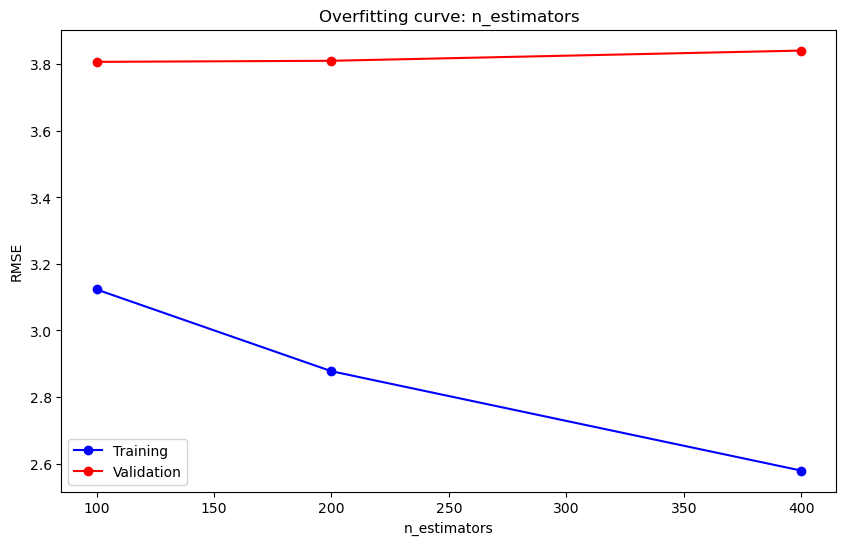

In [129]:
%%time 
test_param_and_plot(XGBRegressor, 'n_estimators', [100, 200, 400], **best_params)

In [132]:
best_params['n_estimators'] = 100

CPU times: total: 1min 7s
Wall time: 7.93 s


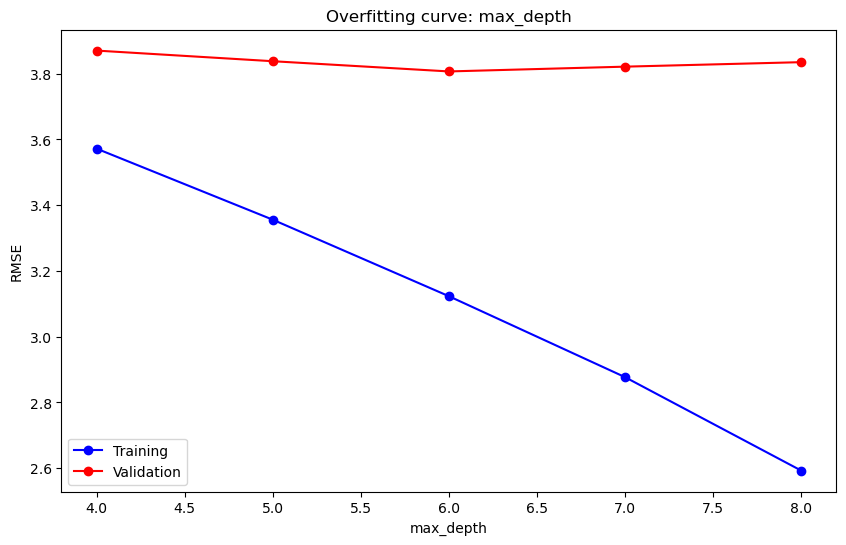

In [134]:
%%time 
test_param_and_plot(XGBRegressor, 'max_depth', range(4,9), **best_params)

In [135]:
best_params['max_depth'] = 6

CPU times: total: 44.3 s
Wall time: 5.98 s


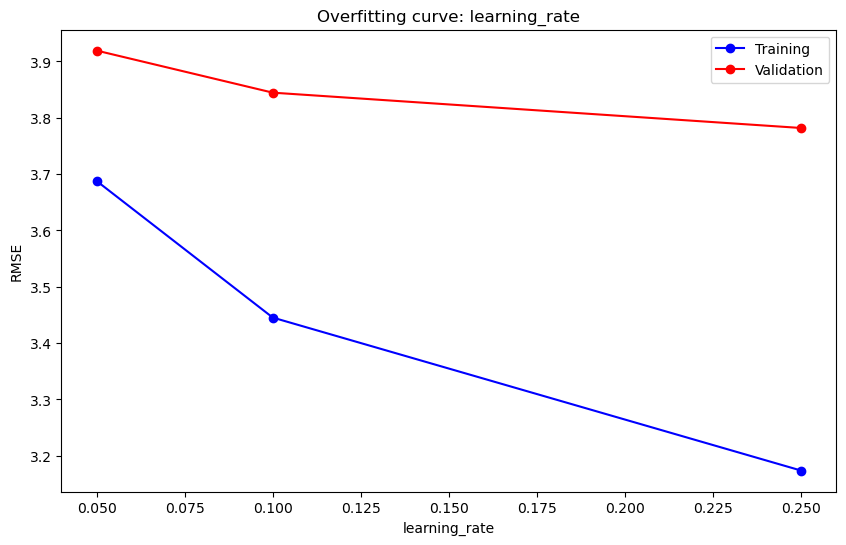

In [136]:
%%time
test_param_and_plot(XGBRegressor, 'learning_rate', [0.05, 0.1, 0.25], **best_params)

In [137]:
xgb_model_final = XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=67,
                               n_estimators=500, max_depth=8, learning_rate=0.08, 
                               subsample=0.8, colsample_bytree=0.8)

In [138]:
%%time
xgb_model_final.fit(train_inputs, train_targets)

CPU times: total: 1min 21s
Wall time: 11 s


,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [139]:
evaluate(xgb_model_final)

(2.453218460083008,
 3.7599246501922607,
 array([ 6.733461 , 14.023965 , 11.245795 , ...,  4.531861 , 33.979935 ,
         5.7218075], shape=(432594,), dtype=float32),
 array([30.298218,  4.118199, 12.753347, ..., 12.248688, 11.456702,
        11.07266 ], shape=(107990,), dtype=float32))